# Tutorial 3: Iterative self-consistent approach to the committor function

In this tutorial we will compute the committor function using our self-consistent iterative procedure.
We will go throught the iteration needed to have a good estimate of the committor, thus alternating cycles of training with cycles of sampling.

# Import modules

In [1]:
# general libs
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# mlcolvar modules we already know
from mlcolvar.utils.plot import paletteFessa
from mlcolvar.utils.plot import plot_isolines_2D, muller_brown_potential, muller_brown_mfep

# useful stuff
mfep = np.array(muller_brown_mfep())

# in the case of MB potential we can obtain a reference committor via numerical intergation
reference_committor_model = torch.jit.load('./model_committor_reference.pt').to(torch.float64).to(torch.device('cpu'))

# as the training of the committor can easily reach very low values, especially the gradients, double precision is a safer choice
torch.set_default_dtype(torch.float64)

Silly utils to move models to the right device and dtype

In [2]:
def convert_model(model_name, n_input):
    loaded_model = torch.jit.load(model_name).to(torch.device('cpu')).to(torch.float32)
    fake_input = torch.rand(n_input).to(torch.float32)
    loaded_model(fake_input)
    frozen_model = torch.jit.trace(loaded_model, fake_input)
    torch.jit.save(frozen_model, model_name)

# Initialize general variables

In [3]:
from mlcolvar.cvs.committor.utils import initialize_committor_masses

# temperature
T = 1 
# Boltzmann factor in the RIGHT ENERGY UNITS! Here we are lucky :)
kb = 1
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

# this helper function initializes the masses array with the right shape already to be used in the variational loss
# it's more useful for real systems :)
atomic_masses = initialize_committor_masses(atom_types=[0], masses=[1], n_dims=2)

Beta: 1.0 
1/beta: 1.0


# Iteration 0: unbiased data only
At this stage, our committor guess will not be much more than a classifier as we only have access to unbiased data from the metastable states!

### Load data

In [4]:
from mlcolvar.data import DictDataset,DictModule
from mlcolvar.utils.io import load_dataframe,create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights

folder = "../1_enhanced_sampling/simulations/unbiased_sims"
filenames = ["A/COLVAR", 
             "B/COLVAR"]

# we generate the dataset for the training 
dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               folder=folder,
                                               create_labels = True,
                                               filter_args={'regex': 'p.x|p.y'},
                                               return_dataframe=True,
                                               stop = 8000,
                                               stride=4)

# we are using unbiased simulations, so we need to create a zeros tensor for the bias 
bias = torch.zeros(len(dataset))

# we need to compute the weights to be used in the variational principle starting from the bias values 
dataset = compute_committor_weights(dataset=dataset,        # dataset to update
                                    bias=bias,              # bias values tensor
                                    data_groups=[0, 1],     # each loaded file has a label, this maps them to the corresponding iteration
                                    beta=beta)              # inverse temperature

# we can use a single batch and no validation set for the training
datamodule = DictModule(dataset=dataset, lengths=[1])

Class 0 dataframe shape:  (2000, 17)
Class 1 dataframe shape:  (2000, 17)

 - Loaded dataframe (4000, 17): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'lwall_x.bias', 'lwall_x.force2', 'uwall_x.bias', 'uwall_x.force2', 'lwall_y.bias', 'lwall_y.force2', 'uwall_y.bias', 'uwall_y.force2', 'walker', 'labels']
 - Descriptors (4000, 2): ['p.x', 'p.y']


#### Initialize model

In [5]:
# import the Committor class 
from mlcolvar.cvs import Committor

# setup lr scheduler for lr decay, this helps convergence
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

# define model options, we can pass the optimizer and the scheduler this way
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.99999 }}

# initialize model
model = Committor(layers=[2, 32, 32, 1],    # NN arch
                  mass=atomic_masses,       # masses for variational functional, see previous function
                  alpha=1e-1,                 # scaling term for variational and boundary losses
                  delta_f=0,                # (guess of) the delta in free energy between the two states, facilitates the training
                  options=options)

#### Train model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio@iit.local/Bin/miniconda3/envs/mlcolvar_pytorch2.2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type           | Params | In sizes | Out sizes
------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | ?        | ?        
1 | nn      | FeedForward    | 1.2 K  | 

Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 74.95it/s, v_num=10] 

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 48.92it/s, v_num=10]


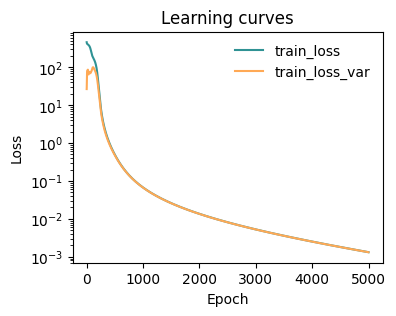

In [6]:
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.utils.plot import plot_metrics

# define callbacks for the training
metrics = MetricsCallback()

# initialize trainer
trainer = lightning.Trainer(callbacks=[metrics], 
                            max_epochs=5000,            # this trainings take a while
                            logger=None, 
                            enable_checkpointing=False,
                            limit_val_batches=0,        # these two options are to use single batch a no validation
                            num_sanity_val_steps=0)     # these two options are to use single batch a no validation

# fit model on our datamodule
trainer.fit(model, datamodule)

# plot metrics
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics=metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log',
                  ax=ax)

#### Visualize results

As we will repeat the same tasks through the iterations, we can define some helper functions to be faster

/tmp/ipykernel_3341344/3710450596.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987277512/work/torch/csrc/utils/tensor_new.cpp:275.)
  bias_mfep = bias_model(torch.Tensor([mfep]).squeeze(0))


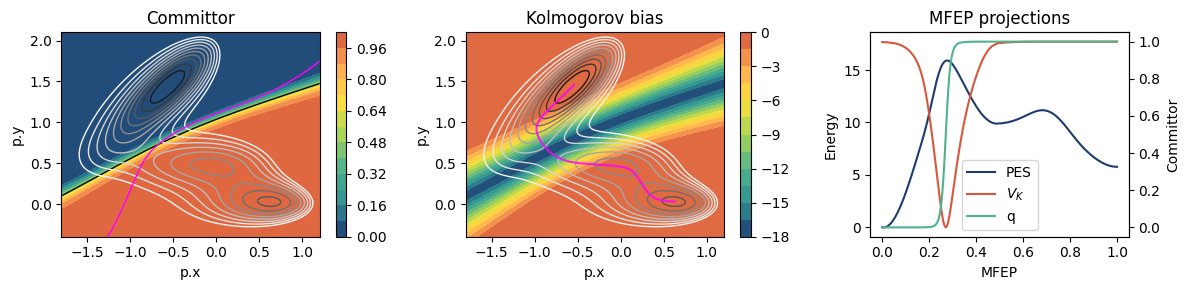

In [15]:
from mlcolvar.cvs.committor.utils import KolmogorovBias

def visualize_trained_model(model):
    # initialize Kolmogorov bias computation, we only use it for representation purposes
    bias_model = KolmogorovBias(model, beta=beta)

    # compute quantities on mfep
    pes_mfep = muller_brown_potential(mfep[:, 0], mfep[:, 1])
    bias_mfep = bias_model(torch.Tensor([mfep]).squeeze(0))
    with torch.no_grad():
        q_mfep = model(torch.Tensor([mfep]).squeeze(0))

    # plot stuff
    fig, axs = plt.subplots(1,3,figsize=(12,3), gridspec_kw={"width_ratios" : [5,5,4]})

    # plot committor
    ax = axs[0]
    plot_isolines_2D(model, ax=ax, colorbar=True)
    plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
    plot_isolines_2D(reference_committor_model, ax=ax, levels=[0.5], mode='contour', linewidths=1, cmap='spring')
    ax.set_title('Committor')
    ax.set_xlabel('p.x')
    ax.set_ylabel('p.y')

    # plot Kolmogorov bias
    ax = axs[1]
    plot_isolines_2D(bias_model, ax=ax, colorbar=True, allow_grad=True)
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
    ax.plot(mfep[:, 0], mfep[:, 1], color='magenta', alpha=0.8)
    ax.set_title('Kolmogorov bias')
    ax.set_xlabel('p.x')
    ax.set_ylabel('p.y')

    # plot projections on the minimum free energy path (MFEP)
    ax = axs[2]
    pes  = ax.plot(np.linspace(0,1,200), pes_mfep, c=paletteFessa[0], label='PES')
    bias = ax.plot(np.linspace(0,1,200), bias_mfep - bias_mfep.min(), c=paletteFessa[6], label='$V_K$')

    ax2 = ax.twinx()
    q = ax2.plot(np.linspace(0,1,200), q_mfep, c=paletteFessa[2], label='q')

    lns = pes+bias+q
    labs = [l.get_label() for l in lns]

    ax.legend(lns, labs, loc=0)
    ax.set_title('MFEP projections')
    ax.set_xlabel('MFEP')
    ax.set_ylabel('Energy')
    ax2.set_ylabel('Committor')

    plt.tight_layout()
    plt.show()

# we can now plot
visualize_trained_model(model)

#### Export trained model to torchscript

In [8]:
# number of iteration
iter = 0

# export q model
model.to_torchscript(f'models/model_{iter}_q.pt', method='trace')

# this ensures everything is on the right device and with the right dtype
convert_model(f'models/model_{iter}_q.pt', 2)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcolvar_pytorch2.2/lib/python3.9/site-packages/torch/jit/_trace.py:795: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


#### Run plumed simulations

In [9]:
RUN_SIMULATION = f"cd biased_sims && bash generate_and_run_sims.sh {iter}" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash')

folder iter_0


generate_and_run_sims.sh: line 34: wait: pid 1 is not a child of this shell


CompletedProcess(args='cd biased_sims && bash generate_and_run_sims.sh 0', returncode=0)

No protocol specified
No protocol specified


#### Visualize sampling
Also here we can create a simple function to repeat over the iterations

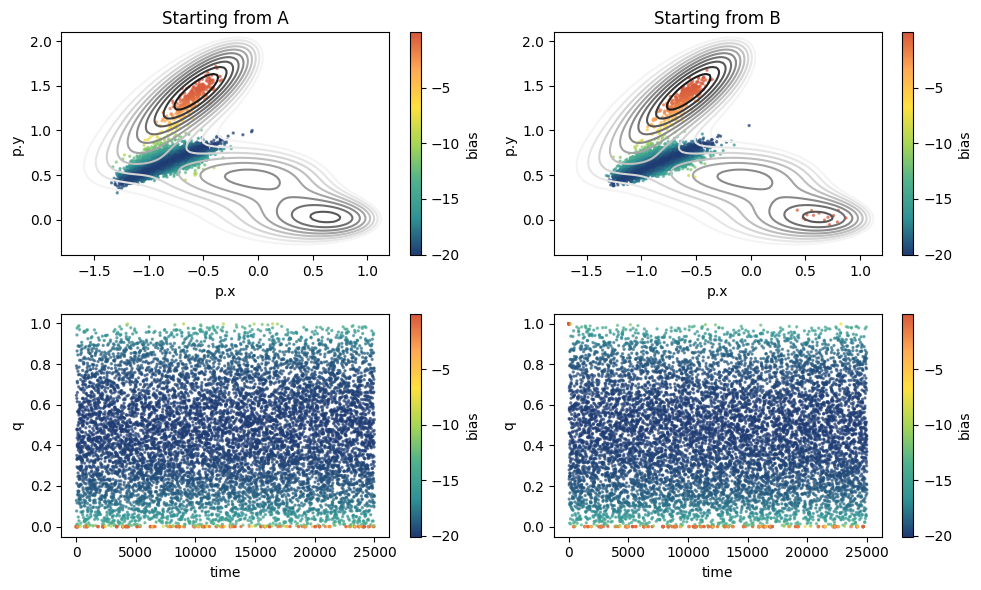

In [8]:
# load data
sampling = load_dataframe([f'biased_sims/iter_{iter}/A/COLVAR', f'biased_sims/iter_{iter}/B/COLVAR'], start=0)

def plot_sampling_results(data):
    fig, axs = plt.subplots(2,2,figsize=(10,6))

    for i,s in enumerate(['A', 'B']):
        ax = axs[0, i]
        plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
        temp = sampling[sampling['walker'] == i]
        cp = ax.scatter(temp['p.x'], temp['p.y'], c=temp['bias'], cmap='fessa',s=2, alpha=0.6)
        ax.set_xlabel('p.x')
        ax.set_ylabel('p.y')
        ax.set_title(f'Starting from {s}')
        cbar = plt.colorbar(cp, ax=ax, label = 'bias')
        cbar.solids.set(alpha=1)


        ax = axs[1, i]
        ax.scatter(temp['time'], temp['q.node-0'], c=temp['bias'], cmap='fessa',s=2, alpha=0.6)
        ax.set_xlabel('time')
        ax.set_ylabel('q')
        cbar = plt.colorbar(cp, ax=ax, label = 'bias')
        cbar.solids.set(alpha=1)
    plt.tight_layout()
    plt.show()

# we can plot now
plot_sampling_results(sampling)

# Iteration 1: we include first biased data 
At this stage, our committor guess will start to improve!

### Load data

In [9]:
filenames = ["../1_enhanced_sampling/simulations/unbiased_sims/A/COLVAR", 
             "../1_enhanced_sampling/simulations/unbiased_sims/B/COLVAR",
             "biased_sims/iter_0/A/COLVAR",
             "biased_sims/iter_0/B/COLVAR"]

load_args = [{'start' : 0, 'stop': 8000, 'stride': 4},
             {'start' : 0, 'stop': 8000, 'stride': 4},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
            ]

# we generate the dataset for the training 
dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               folder=None,
                                               create_labels = True,
                                               filter_args={'regex': 'p.x|p.y'},
                                               return_dataframe=True,
                                               load_args=load_args
                                               )

# fill empty entries of the bias column from unbiased simulations
dataframe = dataframe.fillna({'bias': 0})
bias = torch.Tensor(dataframe['bias'].values)

# we need to compute the weights to be used in the variational principle starting from the bias values 
dataset = compute_committor_weights(dataset=dataset,                # dataset to update
                                    bias=bias,                      # bias values tensor
                                    data_groups=[0, 1, 2, 2],       # each loaded file has a label, this maps them to the corresponding iteration
                                    beta=beta)                      # inverse temperature

# we can use a single batch and no validation set for the training
datamodule = DictModule(dataset=dataset, lengths=[1])

Class 0 dataframe shape:  (2000, 17)
Class 1 dataframe shape:  (2000, 17)
Class 2 dataframe shape:  (10000, 18)
Class 3 dataframe shape:  (10000, 18)

 - Loaded dataframe (24000, 26): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'lwall_x.bias', 'lwall_x.force2', 'uwall_x.bias', 'uwall_x.force2', 'lwall_y.bias', 'lwall_y.force2', 'uwall_y.bias', 'uwall_y.force2', 'walker', 'labels', 'q.node-0', 'q.bias-0', 'bias', '@7.bias', '@7.bias_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2']
 - Descriptors (24000, 2): ['p.x', 'p.y']


#### Initialize model

In [10]:
# setup lr scheduler for lr decay, this helps convergence
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

# define model options, we can pass the optimizer and the scheduler this way
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.99999 }}

# initialize model
model = Committor(layers=[2, 32, 32, 1],    # NN arch
                  mass=atomic_masses,       # masses for variational functional, see previous function
                  alpha=1e-1,                 # scaling term for variational and boundary losses
                  delta_f=0,                # (guess of) the delta in free energy between the two states, facilitates the training
                  options=options)

#### Train model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio@iit.local/Bin/miniconda3/envs/mlcolvar_pytorch2.2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type           | Params | In sizes | Out sizes
------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | ?        | ?        
1 | nn      | FeedForward    | 1.2 K  | 

Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 60.44it/s, v_num=11] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 43.12it/s, v_num=11]


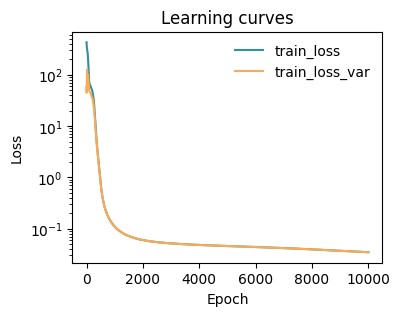

In [11]:
# define callbacks for the training
metrics = MetricsCallback()

# initialize trainer
trainer = lightning.Trainer(callbacks=[metrics], 
                            max_epochs=10000,            # this trainings take a while
                            logger=None, 
                            enable_checkpointing=False,
                            limit_val_batches=0,        # these two options are to use single batch a no validation
                            num_sanity_val_steps=0)     # these two options are to use single batch a no validation

# fit model on our datamodule
trainer.fit(model, datamodule)

# plot metrics
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics=metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log',
                  ax=ax)

#### Visualize results

We can now directly use the previous function

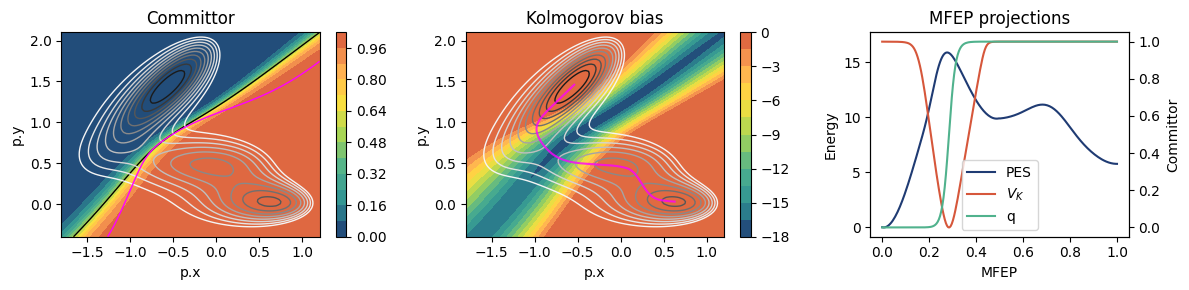

In [16]:
# Visualize trained model
visualize_trained_model(model)

#### Export trained model to torchscript

In [13]:
# number of iteration
iter = 1

# export q model
model.to_torchscript(f'models/model_{iter}_q.pt', method='trace')

# this ensures everything is on the right device and with the right dtype
convert_model(f'models/model_{iter}_q.pt', 2)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcolvar_pytorch2.2/lib/python3.9/site-packages/torch/jit/_trace.py:795: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


#### Run plumed simulations

In [17]:
RUN_SIMULATION = f"cd biased_sims && bash generate_and_run_sims.sh {iter}" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash')

folder iter_1


generate_and_run_sims.sh: line 34: wait: pid 1 is not a child of this shell


CompletedProcess(args='cd biased_sims && bash generate_and_run_sims.sh 1', returncode=0)

No protocol specified
No protocol specified


#### Visualize sampling
Also here we can use the previous function

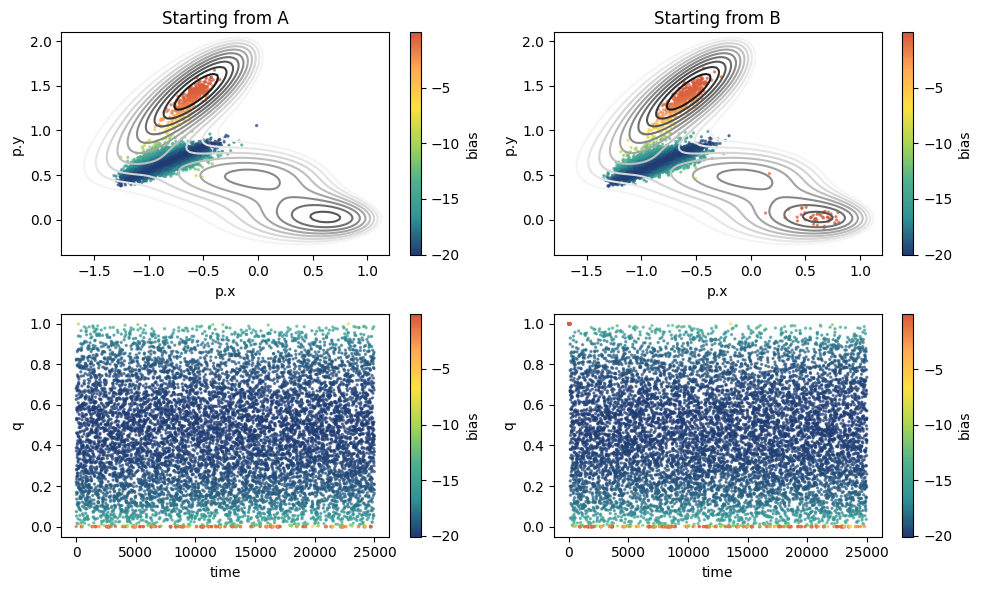

In [24]:
# load data
sampling = load_dataframe([f'biased_sims/iter_{iter}/A/COLVAR', f'biased_sims/iter_{iter}/B/COLVAR'], start=0)

# we can plot now
plot_sampling_results(sampling)

# Iteration 2: we expand our dataset further 

### Load data

In [25]:
filenames = ["../1_enhanced_sampling/simulations/unbiased_sims/A/COLVAR", 
             "../1_enhanced_sampling/simulations/unbiased_sims/B/COLVAR",
             "biased_sims/iter_0/A/COLVAR",
             "biased_sims/iter_0/B/COLVAR",
             "biased_sims/iter_1/A/COLVAR",
             "biased_sims/iter_1/B/COLVAR"]

load_args = [{'start' : 0, 'stop': 8000, 'stride': 4},
             {'start' : 0, 'stop': 8000, 'stride': 4},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
            ]

# we generate the dataset for the training 
dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               folder=None,
                                               create_labels = True,
                                               filter_args={'regex': 'p.x|p.y'},
                                               return_dataframe=True,
                                               load_args=load_args
                                               )

# fill empty entries of the bias column from unbiased simulations
dataframe = dataframe.fillna({'bias': 0})
bias = torch.Tensor(dataframe['bias'].values)

# we need to compute the weights to be used in the variational principle starting from the bias values 
dataset = compute_committor_weights(dataset=dataset,                    # dataset to update
                                    bias=bias,                          # bias values tensor
                                    data_groups=[0, 1, 2, 2, 3, 3],     # each loaded file has a label, this maps them to the corresponding iteration
                                    beta=beta)                          # inverse temperature

# we can use a single batch and no validation set for the training
datamodule = DictModule(dataset=dataset, lengths=[1])

Class 0 dataframe shape:  (2000, 17)
Class 1 dataframe shape:  (2000, 17)
Class 2 dataframe shape:  (10000, 18)
Class 3 dataframe shape:  (10000, 18)
Class 4 dataframe shape:  (10000, 18)
Class 5 dataframe shape:  (10000, 18)

 - Loaded dataframe (44000, 26): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'lwall_x.bias', 'lwall_x.force2', 'uwall_x.bias', 'uwall_x.force2', 'lwall_y.bias', 'lwall_y.force2', 'uwall_y.bias', 'uwall_y.force2', 'walker', 'labels', 'q.node-0', 'q.bias-0', 'bias', '@7.bias', '@7.bias_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2']
 - Descriptors (44000, 2): ['p.x', 'p.y']


#### Initialize model

In [29]:
# setup lr scheduler for lr decay, this helps convergence
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

# define model options, we can pass the optimizer and the scheduler this way
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.99999 }}

# initialize model
model = Committor(layers=[2, 32, 32, 1],    # NN arch
                  mass=atomic_masses,       # masses for variational functional, see previous function
                  alpha=1e-1,                 # scaling term for variational and boundary losses
                  delta_f=0,                # (guess of) the delta in free energy between the two states, facilitates the training
                  options=options)

#### Train model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type           | Params | In sizes | Out sizes
------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | ?        | ?        
1 | nn      | FeedForward    | 1.2 K  | [1, 2]   | [1, 1]   
2 | sigmoid | Custom_Sigmoid | 0      | [1, 1]   | [1, 1]   
------------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Epoch 14999: 100%|██████████| 1/1 [00:00<00:00, 43.93it/s, v_num=13] 

`Trainer.fit` stopped: `max_epochs=15000` reached.


Epoch 14999: 100%|██████████| 1/1 [00:00<00:00, 33.97it/s, v_num=13]


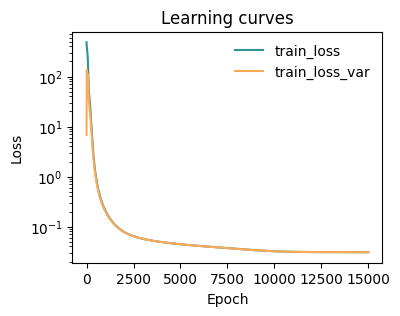

In [30]:
# define callbacks for the training
metrics = MetricsCallback()

# initialize trainer
trainer = lightning.Trainer(callbacks=[metrics], 
                            max_epochs=15000,            # this trainings take a while
                            logger=None, 
                            enable_checkpointing=False,
                            limit_val_batches=0,        # these two options are to use single batch a no validation
                            num_sanity_val_steps=0)     # these two options are to use single batch a no validation

# fit model on our datamodule
trainer.fit(model, datamodule)

# plot metrics
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics=metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log',
                  ax=ax)

#### Visualize results

We can now directly use the previous function

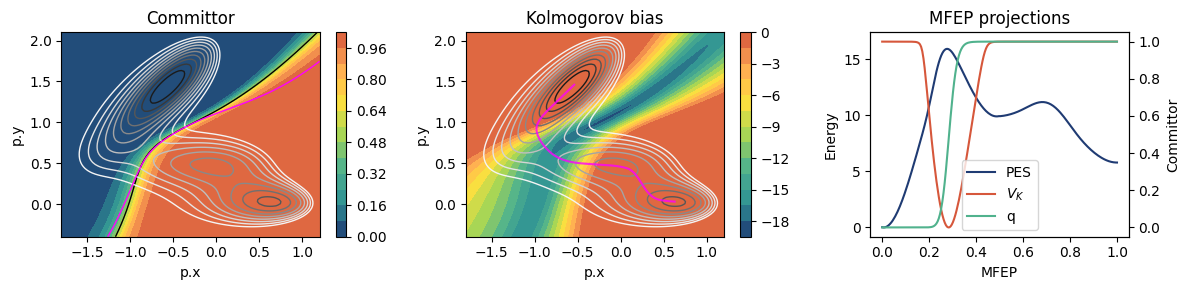

In [31]:
# Visualize trained model
visualize_trained_model(model)

#### Export trained model to torchscript

In [32]:
# number of iteration
iter = 2

# export q model
model.to_torchscript(f'models/model_{iter}_q.pt', method='trace')

# this ensures everything is on the right device and with the right dtype
convert_model(f'models/model_{iter}_q.pt', 2)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcolvar_pytorch2.2/lib/python3.9/site-packages/torch/jit/_trace.py:795: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


#### Run plumed simulations

In [33]:
RUN_SIMULATION = f"cd biased_sims && bash generate_and_run_sims.sh {iter}" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash')

folder iter_2


rm: cannot remove 'iter_2': No such file or directory
generate_and_run_sims.sh: line 34: wait: pid 1 is not a child of this shell


CompletedProcess(args='cd biased_sims && bash generate_and_run_sims.sh 2', returncode=0)

No protocol specified
No protocol specified


#### Visualize sampling
Also here we can use the previous function

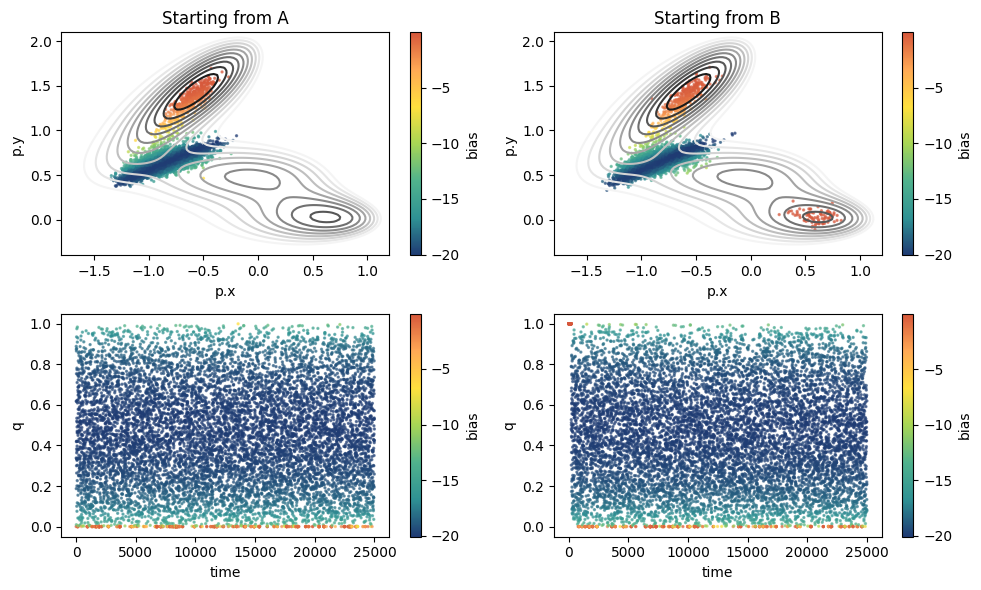

In [40]:
# load data
sampling = load_dataframe([f'biased_sims/iter_{iter}/A/COLVAR', f'biased_sims/iter_{iter}/B/COLVAR'], start=0)

# we can plot now
plot_sampling_results(sampling)

# LAZY ESCAPE: We can also skip some simulations :)

### Load data

In [41]:
folder = "ref_data"
# these can also be found in the mlcolvar docs folder
filenames = ['unbiased/state-0/COLVAR',
             'unbiased/state-1/COLVAR',
             'biased/iter_1/COLVAR_A',
             'biased/iter_1/COLVAR_B',
             'biased/iter_2/COLVAR_A',
             'biased/iter_2/COLVAR_B'
            ]

load_args = [{'start' : 0, 'stop': 2000, 'stride': 1},
             {'start' : 0, 'stop': 2000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
            ]

# we generate the dataset for the training 
dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               folder=folder,
                                               create_labels = True,
                                               filter_args={'regex': 'p.x|p.y'},
                                               return_dataframe=True,
                                               load_args=load_args
                                               )

# fill empty entries of the bias column from unbiased simulations
dataframe = dataframe.fillna({'bias': 0})
bias = torch.Tensor(dataframe['bias'].values)

# we need to compute the weights to be used in the variational principle starting from the bias values 
dataset = compute_committor_weights(dataset=dataset,                    # dataset to update
                                    bias=bias,                          # bias values tensor
                                    data_groups=[0, 1, 2, 2, 3, 3],     # each loaded file has a label, this maps them to the corresponding iteration
                                    beta=beta)                          # inverse temperature

# we can use a single batch and no validation set for the training
datamodule = DictModule(dataset=dataset, lengths=[1])

Class 0 dataframe shape:  (2000, 13)
Class 1 dataframe shape:  (2000, 13)
Class 2 dataframe shape:  (10000, 10)
Class 3 dataframe shape:  (10000, 10)
Class 4 dataframe shape:  (10000, 10)
Class 5 dataframe shape:  (10000, 10)

 - Loaded dataframe (44000, 18): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels', 'q.node-0', 'q.bias-0', 'bias', 'mueller', 'bias.1']
 - Descriptors (44000, 2): ['p.x', 'p.y']


#### Initialize model

In [42]:
# setup lr scheduler for lr decay, this helps convergence
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

# define model options, we can pass the optimizer and the scheduler this way
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.99999 }}

# initialize model
model = Committor(layers=[2, 32, 32, 1],    # NN arch
                  mass=atomic_masses,       # masses for variational functional, see previous function
                  alpha=1e-1,                 # scaling term for variational and boundary losses
                  delta_f=0,                # (guess of) the delta in free energy between the two states, facilitates the training
                  options=options)

#### Train model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type           | Params | In sizes | Out sizes
------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | ?        | ?        
1 | nn      | FeedForward    | 1.2 K  | [1, 2]   | [1, 1]   
2 | sigmoid | Custom_Sigmoid | 0      | [1, 1]   | [1, 1]   
------------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/home/etrizio@iit.local/Bin/miniconda3/envs/mlcolvar_pytorch2.2/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see lo

Epoch 14999: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s, v_num=14] 

`Trainer.fit` stopped: `max_epochs=15000` reached.


Epoch 14999: 100%|██████████| 1/1 [00:00<00:00, 34.69it/s, v_num=14]


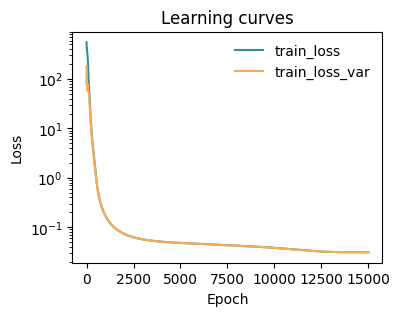

In [43]:
# define callbacks for the training
metrics = MetricsCallback()

# initialize trainer
trainer = lightning.Trainer(callbacks=[metrics], 
                            max_epochs=15000,            # this trainings take a while
                            logger=None, 
                            enable_checkpointing=False,
                            limit_val_batches=0,        # these two options are to use single batch a no validation
                            num_sanity_val_steps=0)     # these two options are to use single batch a no validation

# fit model on our datamodule
trainer.fit(model, datamodule)

# plot metrics
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics=metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log',
                  ax=ax)

#### Visualize results

We can now directly use the previous function

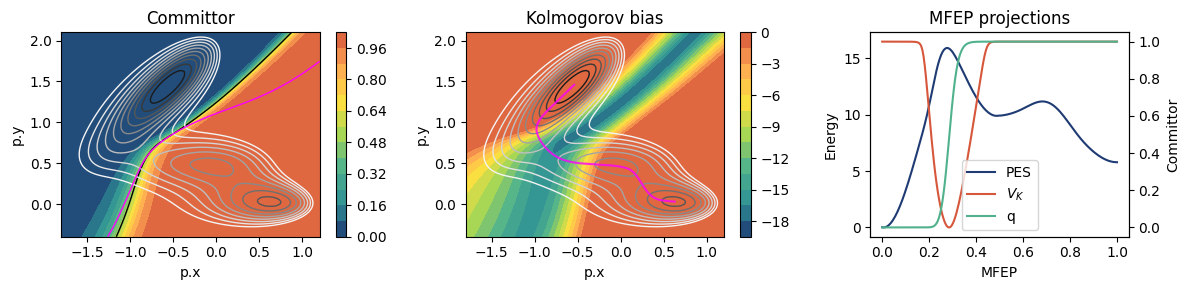

In [44]:
# Visualize trained model
visualize_trained_model(model)

#### Export trained model to torchscript

In [ ]:
# number of iteration
iter = 2

# export q model
model.to_torchscript(f'models/model_{iter}_q.pt', method='trace')

# this ensures everything is on the right device and with the right dtype
convert_model(f'models/model_{iter}_q.pt', 2)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcolvar_pytorch2.2/lib/python3.9/site-packages/torch/jit/_trace.py:795: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


#### Run plumed simulations

In [ ]:
RUN_SIMULATION = f"cd biased_sims && bash generate_and_run_sims.sh {iter}" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash')

#### Visualize sampling
Also here we can use the previous function

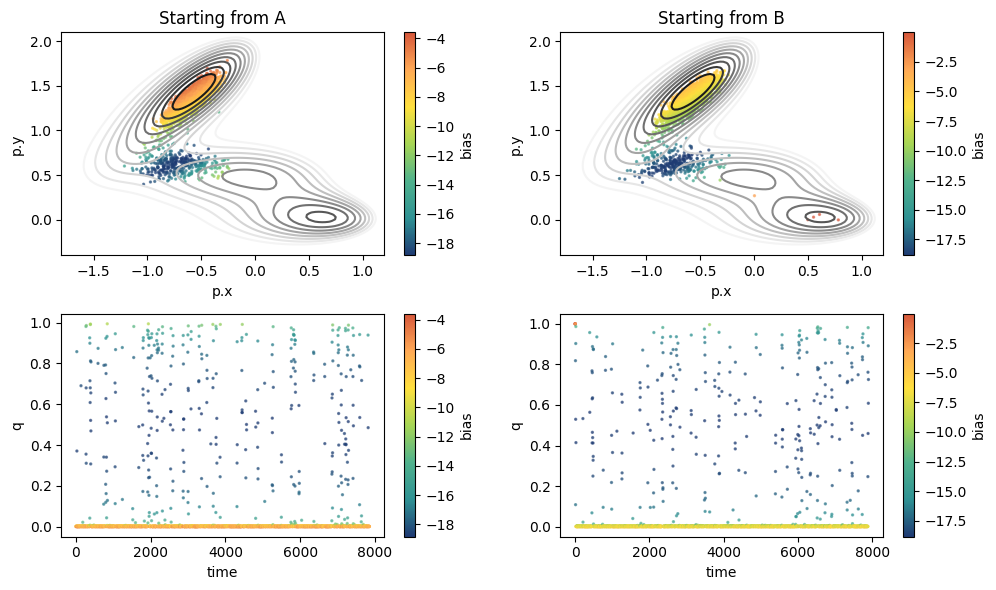

In [ ]:
# load data
sampling = load_dataframe([f'biased_sims/iter_{iter}/A/COLVAR', f'biased_sims/iter_{iter}/B/COLVAR'], start=0)

# we can plot now
plot_sampling_results(sampling)